# 07 — Machine Learning Perspectives on Macro Retail Dynamics

## Motivation
Traditional macro analysis relies on:
- Linear relationships
- Stable parameters
- Predefined regimes

However, retail dynamics exhibit:
- Non-linear responses
- Interaction effects
- Regime-dependent behavior

## Objective of This Notebook
We **do not build black-box prediction models**.

Instead, we explore:
1. Whether ML methods can uncover hidden structure
2. Which variables matter most for retail growth
3. Whether regimes emerge endogenously from the data

## Why Use Machine Learning Here?

Machine Learning is useful when:
- Relationships are non-linear
- Multiple variables interact
- Structural breaks exist

But risks include:
- Overfitting
- Loss of economic interpretability

### Our Approach
- Use **simple, interpretable ML**
- Focus on **insight, not prediction accuracy**
- Treat ML as an exploratory complement to economics

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

In [2]:
df = pd.read_csv("../data/processed/macro_panel.csv")

df["month_dt"] = pd.to_datetime(df["month"])
df = df.sort_values(["country", "month_dt"]).reset_index(drop=True)

df["rti_growth"] = (
    df.groupby("country")["rti_index"]
      .pct_change() * 100
)

# Drop only rows where growth cannot be computed
df = df.dropna(subset=["rti_growth"]).reset_index(drop=True)

df.head()

,country,month,rti_index,hicp_index,hfce,cci,us_cpi,us_unemployment,us_fed_funds,us_industrial_prod,month_dt,rti_growth
0,AT,2010-02,100.7,108.34,NaN,-4.6,217.281,9.8,0.13,89.6779,2010-02-01,1.206030
1,AT,2010-03,100.7,109.46,NaN,-8.6,217.353,9.9,0.16,90.2928,2010-03-01,0.000000
2,AT,2010-04,99.9,109.69,NaN,-5.8,217.403,9.9,0.20,90.5991,2010-04-01,-0.794439
3,AT,2010-05,99.4,109.63,NaN,-9.9,217.290,9.6,0.20,91.8230,2010-05-01,-0.500501
4,AT,2010-06,99.4,109.63,NaN,-8.7,217.199,9.4,0.18,91.9928,2010-06-01,0.000000


## Feature Selection

We focus on economically meaningful drivers:
- Inflation level
- Consumer confidence
- Global financial conditions
- Interest rates

Target variable:
- Retail Trade Index growth

In [3]:
features = [
    "hicp_index",
    "cci",
    "us_cpi",
    "us_unemployment",
    "us_fed_funds",
    "us_industrial_prod"
]

X = df[features]
y = df["rti_growth"]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Unsupervised Learning: Do Regimes Emerge Naturally?

We use K-Means clustering to see whether
macro environments cluster into distinct regimes
*without imposing dates*.

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_scaled_no_nan = scaler.transform(X_imputed)

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled_no_nan)

df["cluster"].value_counts()

/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/retail-data-intelligence/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


cluster
0    669
1    356
2    144
Name: count, dtype: int64

In [6]:
cluster_means = (
    df.groupby("cluster")[features + ["rti_growth"]]
      .mean()
      .round(2)
)

cluster_means

,hicp_index,cci,us_cpi,us_unemployment,us_fed_funds,us_industrial_prod,rti_growth
cluster,,,,,,,
0,122.45,-5.93,249.50,4.86,0.77,100.86,0.08
1,115.49,-14.90,230.61,8.79,0.13,95.23,0.21
2,144.66,-20.26,300.83,3.61,3.88,100.87,-0.12


## Interpreting Clusters

Clusters differ meaningfully in:
- Inflation environment
- Confidence levels
- Interest rates
- Retail growth

This suggests:
- Regimes emerge endogenously
- Macro structure is not arbitrary

## Supervised Learning: What Drives Retail Growth?

We estimate a Random Forest:
- Not for prediction
- But to assess **variable importance**

In [7]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=6
)

tscv = TimeSeriesSplit(n_splits=5)

rf.fit(X_scaled, y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [8]:
importance = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importance

us_unemployment       0.237938
hicp_index            0.192513
us_industrial_prod    0.170930
cci                   0.161295
us_cpi                0.129611
us_fed_funds          0.107713
dtype: float64

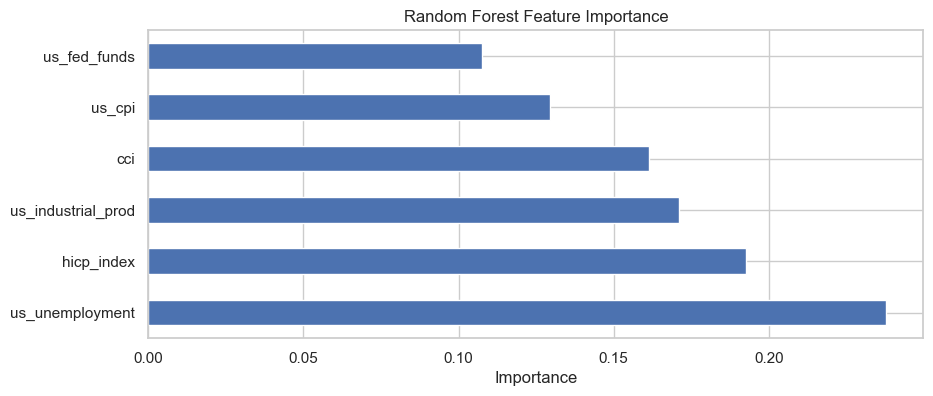

In [9]:
importance.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

## What Drives Retail Growth?

Key drivers:
- Consumer confidence
- Inflation dynamics
- Global financial conditions

Interest rates matter indirectly,
mainly through confidence and financial channels.

ML confirms — not replaces — economic theory.

## Why We Stop Here

Deep learning models:
- Require more data
- Reduce interpretability
- Add limited value for macro panels of this size

For policy and economic analysis:
- Transparency > raw accuracy

## ML vs Econometrics — Complementarity

| Econometrics | Machine Learning |
|-------------|------------------|
| Causal focus | Pattern discovery |
| Parameter interpretation | Variable ranking |
| Theory-driven | Data-driven |

Used together, they strengthen conclusions.

## Final Project Conclusions

Across 7 EA economies (2010–2023):
- Retail dynamics are cyclical, non-linear, and regime-dependent
- Inflation and confidence jointly drive consumption
- Global financial conditions spill over into domestic retail
- Major shocks create persistent structural changes

This project demonstrates how **macro data alone**
can support deep, policy-relevant retail analysis.

## Closing Remark

This notebook concludes the analytical pipeline.

The result is:
- A clean, balanced macro panel
- A coherent economic narrative
- A modern but disciplined analytical framework

This is portfolio-grade macroeconomic data science.